In [1]:
%load_ext tensorboard

from datetime import datetime
from pathlib import Path
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import os


# hyperparameters
batch_size = 128
seed = 1000

# other
logging_dir = './logs/'
grayscale = True

try:
    os.remove(logging_dir)
    print("Removed previous logs")
except:
    print("No previous logs")

# 1) setting up the logging
tensorboard_callback = TensorBoard(log_dir=logging_dir, histogram_freq=1)

#rm -rf ./logs/

No previous logs


In [2]:
train_dir = './CIFAR10/train'
test_dir = './CIFAR10/test'
color_mode = 'rgb' if not grayscale else 'grayscale'
class_names_map = {'0':'airplane', '1':'automobile', '2':'bird', '3':'cat', '4':'deer', '5':'dog', '6':'frog', '7':'horse', '8':'ship', '9':'truck'}
image_size = (28, 28)

train_loader = tf.keras.preprocessing.image_dataset_from_directory(train_dir, labels='inferred', label_mode= 'categorical',
                                                              batch_size=batch_size, color_mode=color_mode, image_size=image_size,
                                                             )
test_loader = tf.keras.preprocessing.image_dataset_from_directory(test_dir, labels='inferred', label_mode= 'categorical',
                                                              batch_size=batch_size, color_mode=color_mode, image_size=image_size,
                                                             )

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [3]:
def check_data_loader_dim(loader):
    # Checking the dataset
    for images, labels in loader:
        print('Image batch dimensions:', images.shape)
        print('Image label dimensions:', labels.shape)
        break

check_data_loader_dim(train_loader)

Image batch dimensions: (128, 28, 28, 1)
Image label dimensions: (128, 10)


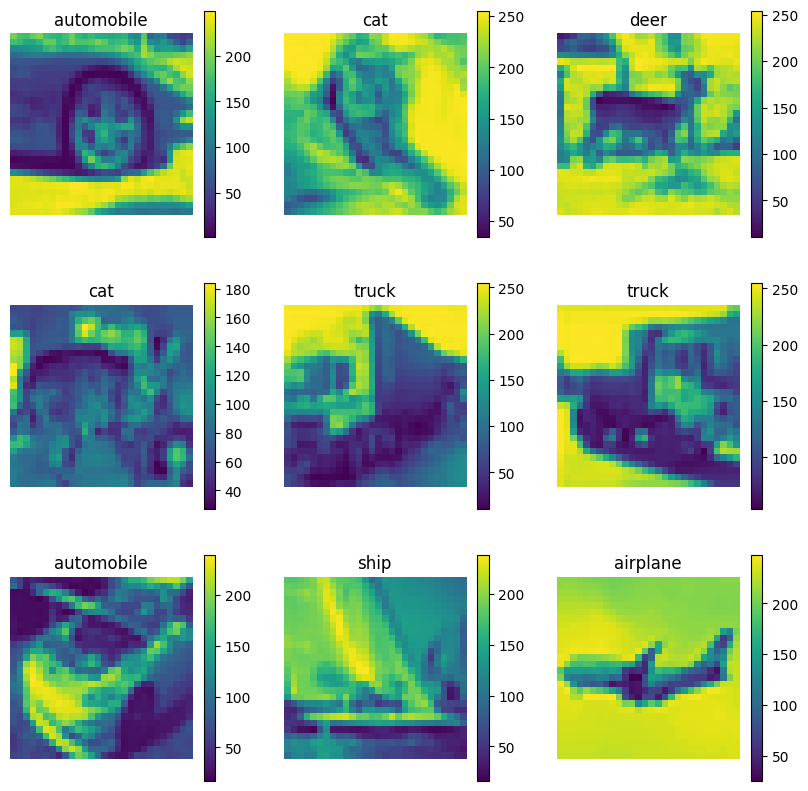

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def one_hot2class_name(label_tensor, class_names):
    "Return the class name of the one hot encoded batch of labels"    
    temp = label_tensor.numpy()
    ind = int(np.argwhere(temp).flatten()[0])
    return class_names[ind]

class_names = [class_names_map[lbl] for lbl in train_loader.class_names]

plt.figure(figsize=(10, 10))
for images, labels in train_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        name = one_hot2class_name(labels[i, :], class_names)
        plt.title(name)
        plt.axis("off")
        plt.colorbar()

In [5]:
images.shape

TensorShape([128, 28, 28, 1])

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_loader = train_loader.cache().shuffle(seed).prefetch(buffer_size=AUTOTUNE)
test_loader = test_loader.cache().prefetch(buffer_size=AUTOTUNE)

## Build LeNet

In [155]:
from keras.models import Sequential
from keras.layers import Input, Rescaling, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, BatchNormalization
from keras.regularizers import L1, L2
from keras.activations import relu, leaky_relu

#activation = leaky_relu(x, negative_slope=0.2)

model = Sequential()
model.add(Input(shape=(28, 28, 1)))
model.add(Rescaling(1./255))

model.add(Conv2D(32, kernel_size=(5, 5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(2))

model.add(Conv2D(64, kernel_size=(5, 5)))
model.add(BatchNormalization())      
model.add(Activation('relu'))

model.add(MaxPooling2D(2))

model.add(Flatten())

model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_34 (Rescaling)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_60 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 8, 8, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_61 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_30 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,112,330 (4.24 MB)

 Trainable params: 1,112,138 (4.24 MB)

 Non-trainable params: 192 (768.00 B)

In [156]:
epochs = 30
lr = 0.001 # Higher is worse
beta_1 = 0.9 # 0.9 # Dont really matter can use 0.5
beta_2 = 0.999 # 0.999 # Lower learns slower

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)#, beta_1=beta_1, beta_2=beta_2) 
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) # Try sparse cross entropy
history = model.fit(train_loader, epochs=epochs, validation_data=test_loader, callbacks=[tensorboard_callback])

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.2470 - loss: 2.6305 - val_accuracy: 0.1000 - val_loss: 2.8370
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4253 - loss: 1.5822 - val_accuracy: 0.1040 - val_loss: 3.6863
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5307 - loss: 1.3275 - val_accuracy: 0.1000 - val_loss: 3.8746
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5982 - loss: 1.1522 - val_accuracy: 0.1580 - val_loss: 3.2069
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6367 - loss: 1.0346 - val_accuracy: 0.2070 - val_loss: 3.1125
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6926 - loss: 0.8986 - val_accuracy: 0.2930 - val_loss: 2.3649
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7233 - loss: 0.7888 - val_accuracy: 0.3950 - val_loss: 1.7518
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.7691 - loss: 0.6817 - val_accuracy: 0.4910 - v

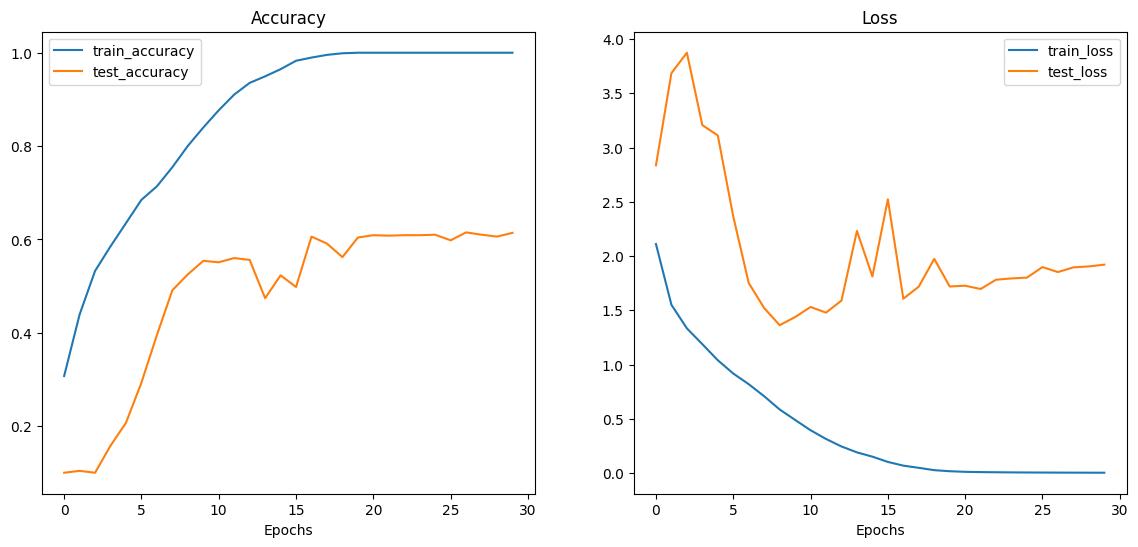

In [157]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
axs[0].plot(history.history['accuracy'], label='train_accuracy')
axs[0].plot(history.history['val_accuracy'], label='test_accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend()

# Loss
axs[1].plot(history.history['loss'], label='train_loss')
axs[1].plot(history.history['val_loss'], label='test_loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

In [23]:
%tensorboard --logdir logs/train
# tensorboard --logdir hw2/logs/train

In [19]:

os.remove(logging_dir)
print("Removed previous logs")


PermissionError: [WinError 5] Access is denied: './logs/train'

## Visualize the Network

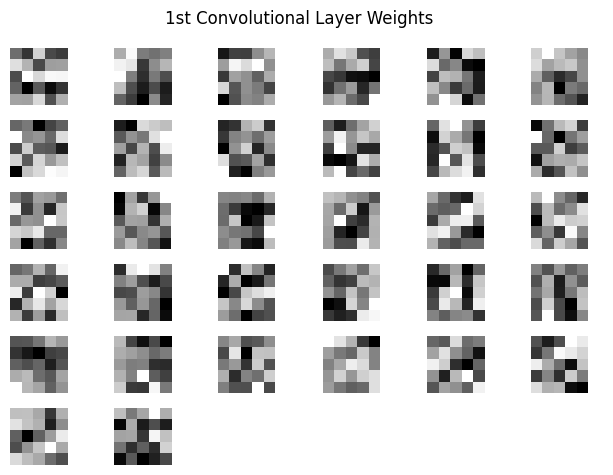

In [121]:

# Weights of the desired convolutional layer
layer_name = 'conv2d_60'  
conv_layer = model.get_layer(layer_name)
weights = conv_layer.get_weights()[0]  

def plot_tensor(tensor_3d, title_str=''):
    "Plots the values in 3D tensor along last axis"
    
    n_sqrt = int(np.ceil(np.sqrt(tensor_3d.shape[-1] )))
    fig, axes = plt.subplots(nrows=n_sqrt, ncols=n_sqrt)#, figsize=(5, 15))
    axes = axes.reshape((n_sqrt, -1))

    for i in range(n_sqrt):
        for j in range(n_sqrt):
            num = i * n_sqrt + j
            if num >= tensor_3d.shape[-1]:
                axes[i, j].axis('off')
                continue
            axes[i, j].imshow(tensor_3d[:, :, 0, num], cmap='gray')
            axes[i, j].axis('off')

    fig.suptitle(title_str)
    plt.tight_layout()
    plt.show()
    
plot_tensor(weights, title_str='1st Convolutional Layer Weights')

In [145]:
weights.shape

(5, 5, 1, 32)

## Activation Stats

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


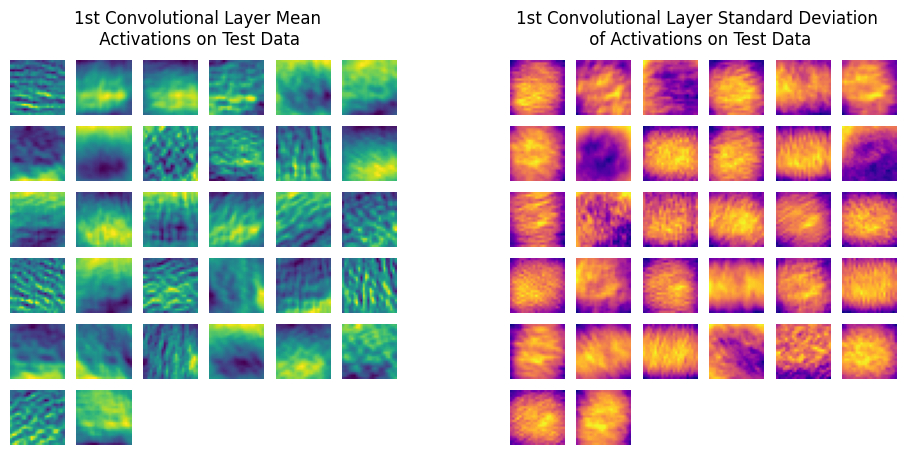

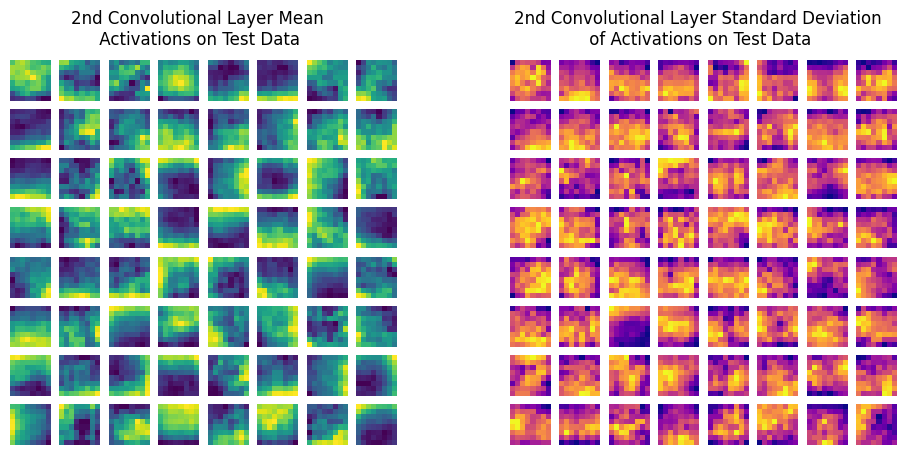

In [151]:
# Define a function to get the activation
def get_layer_activations(model, layer_name, input_data):
    layer = model.get_layer(layer_name)
    layer_output = layer.output
    get_activation = tf.keras.Model(model.inputs[0], layer_output)
    activation = get_activation.predict(input_data)
    return activation

def plot_activations(activations, titles_str=''):
    "Plots the activation distribution along last axis"
    
    n_sqrt = int(np.ceil(np.sqrt(activations.shape[-1] )))
    
    fig = plt.figure(figsize=(10, 5))
    subfigs = fig.subfigures(1, 2, wspace=0.0)
    axes_mean = subfigs[0].subplots(nrows=n_sqrt, ncols=n_sqrt)
    axes_mean = axes_mean.reshape((n_sqrt, -1))    
    axes_std = subfigs[1].subplots(nrows=n_sqrt, ncols=n_sqrt)
    axes_std = axes_std.reshape((n_sqrt, -1))
    
    mean_act = np.mean(activations, axis=0)
    std_act = np.std(activations, axis=0)

    for i in range(n_sqrt):
        for j in range(n_sqrt):
            num = i * n_sqrt + j
            if num >= activations.shape[-1]:
                axes_mean[i, j].axis('off')
                axes_std[i, j].axis('off')
                continue
            # Mean
            axes_mean[i, j].imshow(mean_act[:, :, num])
            axes_mean[i, j].axis('off')
            
            # Std
            axes_std[i, j].imshow(std_act[:, :, num], cmap='plasma')
            axes_std[i, j].axis('off')

    subfigs[0].suptitle(titles_str[0])
    subfigs[1].suptitle(titles_str[1])
    #plt.tight_layout()


conv1_act = get_layer_activations(model, 'conv2d_60', test_loader)
conv2_act = get_layer_activations(model, 'conv2d_61', test_loader)


titles_str1=['1st Convolutional Layer Mean\n Activations on Test Data',
                                        '1st Convolutional Layer Standard Deviation\n of Activations on Test Data']
titles_str2=['2nd Convolutional Layer Mean\n Activations on Test Data',
                                        '2nd Convolutional Layer Standard Deviation\n of Activations on Test Data']
plot_activations(conv1_act, titles_str=titles_str1)
plot_activations(conv2_act, titles_str=titles_str2)

plt.show()